In [1]:
import xarray as xr
import zarr
import glob
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def wind_speed(U, V):
    func = lambda x, y: np.sqrt(x**2 + y**2)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

def wind_dir(U, V):
    func = lambda x, y: np.mod(180+np.rad2deg(np.arctan2(x, y)),360)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

In [3]:
zarr_dir = "/home/peter/WRF_MODEL/zarr_out/"
wrf = xr.open_zarr(str(zarr_dir+'d4_1_cpt.zarr'))

Each forecast is 39 hours, this function returns the forecast made x number of succesful forecast runs ago

In [4]:
def get_one_cycle(ds, n):
    steps_in_forecast = 39*4+1
    end = steps_in_forecast*n
    start = steps_in_forecast*(n+1)
    x = wrf.to_array() #convert to DataArray
    if end == 0:
        x =  x[:,-start:]
    else:
        x =  x[:,-start:-end]
    return x.to_dataset(dim = 'variable')

First let's get some observational data to reference against. Here we will use observations from the Cape Town International Airport sourced from the NOAA Integrated Surface Dataset (ISD)- https://www.ncei.noaa.gov/products/land-based-station/integrated-surface-database 

In [5]:
obs_2021 = pd.read_csv('cpt_intl_2021.csv').set_index('DATE')
obs_2022= pd.read_csv('cpt_intl_2022.csv').set_index('DATE')
obs_full = pd.concat([obs_2021, obs_2022])

Some quick data cleaning as the ISD comes in a rather strange format 

In [6]:
wind_df = obs_full['WND'].str.split(',', expand=True).rename(columns = {0:'w_dir', 1:'w_dir_q', 2:'w_type', 3:'w_speed', 4:'w_speed_q'})
wind_df['w_speed'] = wind_df['w_speed'].apply(lambda x: int(x)/10)
wind_df['w_dir'] = wind_df['w_dir'].apply(lambda x: int(x))

temp_df = obs_full['TMP'].str.split(',', expand = True).rename(columns = {0:'temp', 1:'temp_q'})
temp_df['temp'] = temp_df['temp'].apply(lambda x: int(x)/10)
obs = wind_df.join(temp_df)
obs.replace(-999, np.nan, inplace=True)
obs.index = pd.to_datetime(obs.index)

obs = obs.rename(columns = {'temp':'T2', 'w_speed':'ws', 'w_dir':'Dir'})

Let's add the forecast data to the dataframe

In [7]:
latitude = obs_full.LATITUDE[-1]
longitude = obs_full.LONGITUDE[-1]

forecast = get_one_cycle(wrf, 2)

forecast = forecast.sel(lat = latitude, method = 'nearest').sel(lon = longitude, method = 'nearest')
forecast = forecast.resample(time='h').mean(dim= 'time')
forecast['ws'] = forecast['ws']*0.514444444
forecast['T2'] = forecast['T2']-273.15

obs = obs[obs.index.isin(forecast.time.values)]
obs = obs[~obs.index.duplicated(keep='first')]
obs.replace(-999, np.nan, inplace=True)
obs.replace(999, np.nan, inplace=True)

df = obs.join(forecast.to_dataframe()[['ws','Dir','T2']].add_suffix('_WRF'))

And add the 'parent model' GFS as a reference

In [8]:
gfs = xr.open_zarr(str(zarr_dir+'GFS_26032022.zarr'))
gfs = gfs.sel(latitude = latitude, method = 'nearest').sel(longitude = longitude, method = 'nearest')
gfs = gfs.sortby('valid_time')
gfs = gfs.resample(valid_time='h').mean(dim= 'valid_time')
gfs['T2'] = gfs['t2m']-273.15
gfs['ws'] = wind_speed(gfs.u10, gfs.v10)
gfs['Dir'] = wind_dir(gfs.u10, gfs.v10)

In [9]:
df = df.join(gfs.to_dataframe()[['T2', 'ws','Dir']].add_suffix('_GFS'))

In [10]:
df['Forecast_Hour'] = range(len(df))
df = df.set_index('Forecast_Hour')

Let's see how my WRF model and the GFS model performed against observation during this particular forecast cycle 

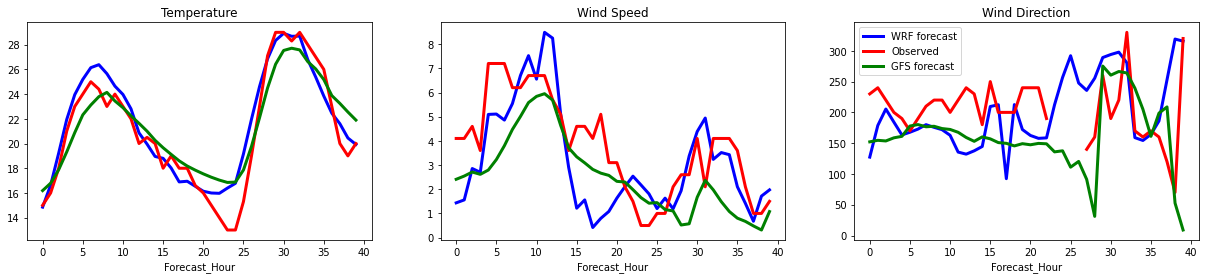

In [11]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(21,4))
axs=axs.flatten()

df.T2_WRF.plot(color = 'Blue', ax = axs[0], lw = 3)
df.T2.plot(color = 'Red' , ax = axs[0], lw = 3)
df.T2_GFS.plot(color = 'Green', ax = axs[0], lw = 3)
axs[0].set_title('Temperature')

df.ws_WRF.plot(color = 'Blue', ax = axs[1], lw = 3)
df.ws.plot(color = 'Red' , ax = axs[1], lw = 3)
df.ws_GFS.plot(color = 'Green', ax = axs[1], lw = 3)
axs[1].set_title('Wind Speed')

df.Dir_WRF.plot(color = 'Blue', ax = axs[2], lw = 3, label = 'WRF forecast')
df.Dir.plot(color = 'Red' , ax = axs[2], lw = 3, label = 'Observed')
df.Dir_GFS.plot(color = 'Green' , ax = axs[2], lw = 3, label = 'GFS forecast')
axs[2].set_title('Wind Direction')
axs[2].legend()

plt.show()

Let's rather view this as a function of squared error

In [12]:
for var in ['T2','ws','Dir']:
    for model in ['WRF','GFS']:
        df[str(var)+'_'+str(model)+'_error'] = np.sqrt((df[str(var)] - df[str(var)+'_'+str(model)]) **2)

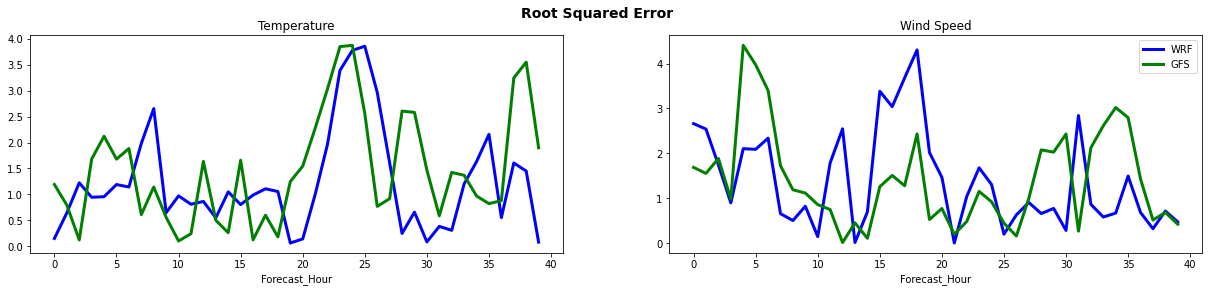

In [23]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(21,4))
axs=axs.flatten()

for i, var in enumerate(['T2','ws']):
    for model,col in zip(['WRF','GFS'],['Blue', 'Green']):
        df[str(var)+'_'+str(model)+'_error'].plot(color = col, ax = axs[i], lw = 3, label = str(model))
        

axs[0].set_title('Temperature')
axs[1].set_title('Wind Speed')
axs[1].legend()

fig.suptitle('Root Squared Error', fontsize=14, fontweight='bold')
plt.show()

In [14]:
for model in ['WRF','GFS']:
    print(str(model), ' RMSE scores over full 39 hour forecast period:')
    for var in ['T2','ws']:
        print(str(var),' error:', np.round(df[str(var)+'_'+str(model)+'_error'].mean(),2))

WRF  RMSE scores over full 39 hour forecast period:
T2  error: 1.22
ws  error: 1.39
GFS  RMSE scores over full 39 hour forecast period:
T2  error: 1.46
ws  error: 1.42


WRF  RMSE scores over full 39 hour forecast period:
    
    T2  error: 1.22

    ws  error: 1.39

GFS  RMSE scores over full 39 hour forecast period:
    
    T2  error: 1.46

    ws  error: 1.42



Thus it seems my WRF model has outperformed the GFS model during this forecast cycle

Next let's contrast the two on a 2 dimensional grid

In [15]:
forecast = get_one_cycle(wrf, 2)

In [16]:
forecast_hour = 30
time = forecast.time.values[forecast_hour*4]

In [17]:
wrf = forecast.sel(time = time)
wrf['T2'] = wrf['T2']-273.15

In [18]:
gfs = xr.open_zarr(str(zarr_dir+'GFS_26032022.zarr'))
gfs = gfs.sel(valid_time = time)

#gfs = gfs.sel(latitude = slice(np.max(wrf.lat.values), np.min(wrf.lat.values))).sel(longitude = slice(np.min(wrf.lon.values), np.max(wrf.lon.values)))
gfs['T2'] = gfs['t2m']-273.15
gfs['ws'] = wind_speed(gfs.u10, gfs.v10)
gfs['Dir'] = wind_dir(gfs.u10, gfs.v10)

It is neccesary to regrid GFS to the same resolution to create an anomaly map

In [19]:
gfs = gfs.interp(latitude=wrf.lat.values).interp(longitude=wrf.lon.values)

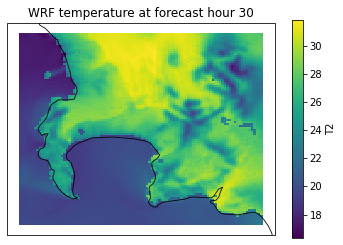

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
wrf.T2.plot(ax=ax,  transform = ccrs.PlateCarree())
ax.coastlines('10m', linewidth=0.8)
ax.set_title('WRF temperature at forecast hour 30')
plt.show()

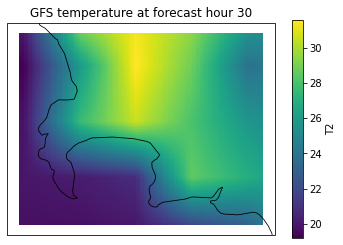

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
gfs.T2.plot(ax=ax,  transform = ccrs.PlateCarree())
ax.coastlines('10m', linewidth=0.8)
ax.set_title('GFS temperature at forecast hour 30')
plt.show()

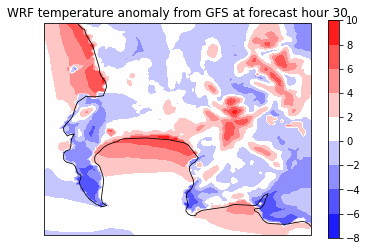

In [22]:
ax = plt.axes(projection=ccrs.PlateCarree())
img = ax.contourf(wrf.lon.values, wrf.lat.values,(gfs.T2.values - wrf.T2.values),cmap = 'bwr',  transform = ccrs.PlateCarree())
ax.coastlines('10m', linewidth=0.8)
plt.colorbar(img, ax=ax)
ax.set_title('WRF temperature anomaly from GFS at forecast hour 30')
plt.show()